# Question 3

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# updating the keras version for importing ops module in the following
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [3]:
import os
import keras
from keras import Model
from keras.layers import Flatten, Dense
from keras.applications.resnet50 import ResNet50
from keras.datasets import cifar10
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import ops
import numpy as np
from keras.models import load_model
import keras_tuner as kt

## Prepare the dataset

The dataset used for training the teacher and distilling the teacher is
Cifar10. Both the student and teacher are trained on the training set and evaluated on the test set.

In [4]:
num_classes = 10
batch_size = 128

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
# input image dimensions
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
print(input_shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print("Number of training data: {} \nNumber of test data: {}\nsize of each picture: ({},{})".format(x_train.shape[0],x_test.shape[0],x_train.shape[1],x_train.shape[2]))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
(32, 32, 3)
Number of training data: 50000 
Number of test data: 10000
size of each picture: (32,32)


## Create teacher model

Initialy, we create a teacher model and a smaller student model. Both models are
convolutional neural networks and created using `Sequential()`,
but could be any Keras model.

In [6]:
# Create the teacher
ResNet50 = keras.applications.ResNet50(include_top=False,
                weights="imagenet",
                input_shape=input_shape,
                classes=num_classes,
                classifier_activation="softmax")
ResNet50.trainable = True
teacher_out = Flatten()(ResNet50.output)
teacher_out = Dense(num_classes, activation='softmax')(teacher_out)
teacher_model = Model(inputs=ResNet50.input, outputs=teacher_out)
teacher_model.name = 'teacher'
teacher_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Train the teacher

In knowledge distillation we assume that the teacher is trained and fixed. Thus, we start
by training the teacher model on the training set in the usual way.

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 111s 139ms/step - loss: 1.4155 - sparse_categorical_accuracy: 0.5359 - val_loss: 3.6970 - val_sparse_categorical_accuracy: 0.3112
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - loss: 0.5817 - sparse_categorical_accuracy: 0.8008 - val_loss: 0.7789 - val_sparse_categorical_accuracy: 0.7512
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.3079 - sparse_categorical_accuracy: 0.8977 - val_loss: 0.7458 - val_sparse_categorical_accuracy: 0.7631
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.7742 - val_sparse_categorical_accuracy: 0.7743
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - loss: 0.1024 - sparse_categorical_accuracy: 0.9691 - val_loss: 0.8604 - val_sparse_categorical_accuracy: 0.7740
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - loss: 0.0821 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.8839 - val_sparse_categorical_accurac

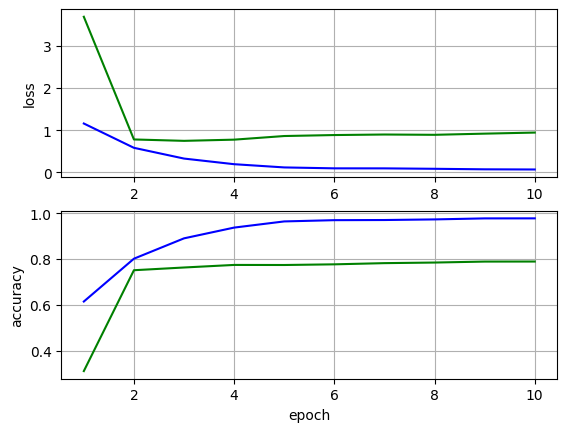

In [9]:
# Train teacher as usual
teacher_model.compile(
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=[keras.metrics.SparseCategoricalAccuracy()]
)
# Train and evaluate teacher on data.
epochs = 10
teacher_history = teacher_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
# plotting the loss and accuracy per epochs
plt.figure()
plt.subplot(2,1,1);
plt.plot(range(1,epochs+1), teacher_history.history['loss'], 'b',
         range(1,epochs+1), teacher_history.history['val_loss'],'g')
plt.ylabel('loss'); plt.grid()
plt.subplot(2,1,2);
plt.plot(range(1,epochs+1), teacher_history.history['sparse_categorical_accuracy'], 'b',
         range(1,epochs+1), teacher_history.history['val_sparse_categorical_accuracy'],'g')
plt.ylabel('accuracy'); plt.grid(); plt.xlabel('epoch')
plt.show()

In [10]:
score=teacher_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9425638914108276
Test accuracy: 0.7890999913215637


In [11]:
teacher_model.save('model_teacher_HW2_3_FineTune_2.h5')

loading my best teacher model and see its result.

In [12]:
teacher_model = load_model('model_teacher_HW2_3_FineTune_2.h5')
teacher_model.summary()
score=teacher_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "teacher"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,204 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 2 (12.00 B)

Test loss: 0.9425638914108276
Test accuracy: 0.7890999913215637


it seems fine tuning the model is better. the weights for Imagenet weren't good for this problem. the accuracy on test data with fine tuning is almost 80%, but the cnn-freeze model got to 50% accuracy (part a). also unbelivabley it took less time and epochs to train. but the model size was very large to download.

### Links of best models

https://drive.google.com/file/d/1jefrTb1L0X-XM-HsPnsGuaow2EEVGQMo/view?usp=drive_link

https://drive.google.com/file/d/1xiwy5UKnQuJ9cy3hYa9DPnvRP6FhyAmc/view?usp=drive_link




# sites

https://keras.io/api/applications/mobilenet/

https://keras.io/api/applications/resnet/#resnet50-function

https://keras.io/api/datasets/cifar10/

https://keras.io/examples/vision/knowledge_distillation/

https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

https://keras.io/guides/keras_tuner/getting_started/#getting-started-with-kerastuner

https://colab.research.google.com/github/sayakpaul/Knowledge-Distillation-in-Keras/blob/master/Distillation_with_Transfer_Learning.ipynb#scrollTo=-QOO3DJuhgTb

https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/knowledge_distillation.ipynb
